In [60]:
import argparse
import os
import random
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import torchvision.utils as vutils
import matplotlib.pyplot as plt
import numpy as np

In [4]:
%pip install torch==1.9.1+cu111 torchvision==0.10.1+cu111 torchaudio==0.9.1 -f https://download.pytorch.org/whl/torch_stable.html


Defaulting to user installation because normal site-packages is not writeable
Looking in links: https://download.pytorch.org/whl/torch_stable.html
You should consider upgrading via the '/usr/local/bin/python3 -m pip install --upgrade pip' command.


# Подгрузка изображений 

In [14]:
%pwd

'/home/jupyter/work/resources'

In [ ]:
! unzip archive.zip -d ~/work/resources

In [61]:
from PIL import Image
import glob

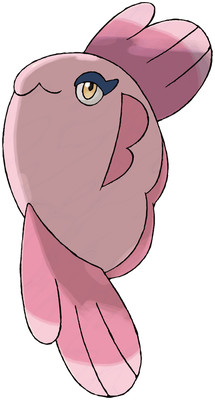

In [62]:
filename = "images/Alomomola/0.jpg"
with Image.open(filename) as img:
    img.show()

In [63]:
# сформируем датасет из изображений 
image_data = []
for image_file in glob.glob('images/**/*.jpg', recursive=True):
    image_data.append(Image.open(image_file))

In [64]:
len(image_data)

2503

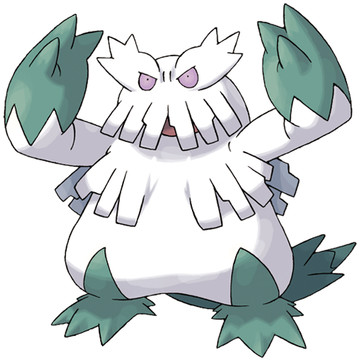

In [65]:
# ура работает!
image_data[0].show()

# Формирование датасета и аугментация данных

In [66]:
# нужен свой класс для удобной обработки данных 
class ImageDataset(Dataset):
    def __init__(self, data, transform):
        self.data = data
        self.transform = transform
        
    def __getitem__(self, index): 
        x = self.data[index]
        
        if self.transform:
            x = self.transform(x)
            
        return x
        
    def __len__(self):
        return len(self.data)

In [67]:
def imshow(img):
    npimg = img.numpy()
    plt.figure(figsize = (30,10))
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

In [211]:
#!g2.mig
transform = transforms.Compose([
       transforms.Resize(size=[64,64]),
       transforms.RandomHorizontalFlip(),
       transforms.RandomRotation(degrees=[0.2, 0.8]),
       transforms.ToTensor()
])

pokemon_dataset = ImageDataset(image_data, transform)
pokemon_loader = DataLoader(pokemon_dataset, batch_size=16, shuffle=True)

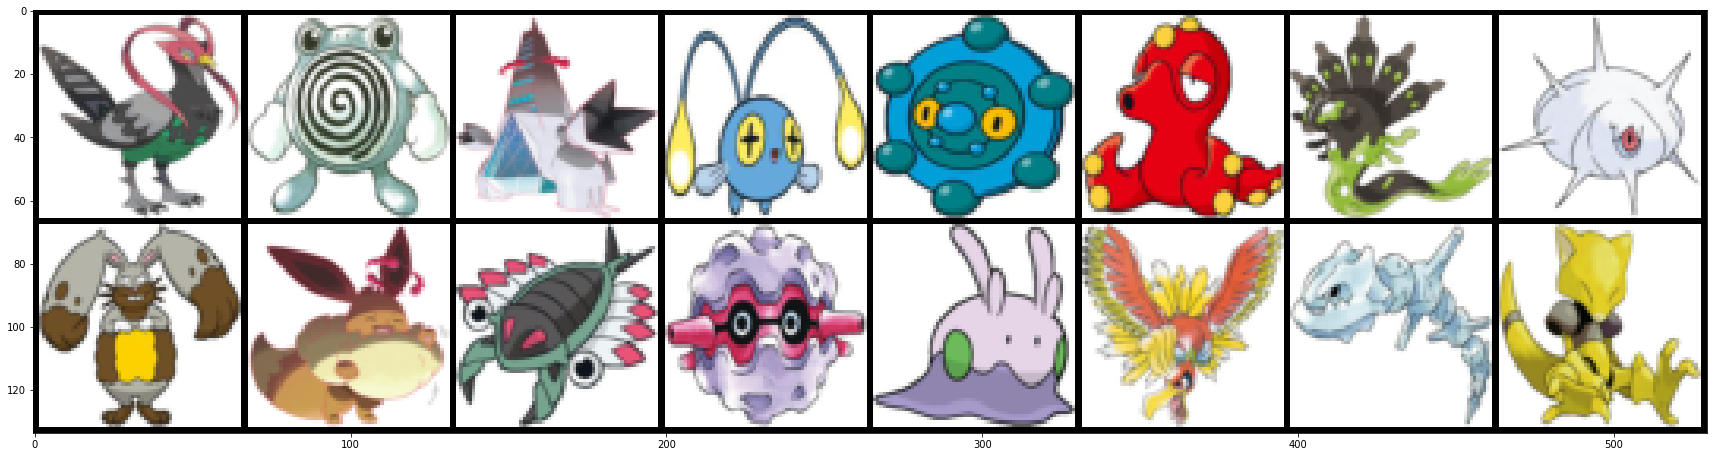

In [212]:
#!g2.mig
pokemon_iter = iter(pokemon_loader)
images = pokemon_iter.next()

imshow(vutils.make_grid(images))

# Модель DCGAN 

In [222]:
#!g2.mig
# Зададим константы 
ngpu = 1 ## обучаем на gpu
batch_size = 16
latent_dim = 100 ## размерность входного вектора шума
n_channels = 3
nf_D = 64 ## карта признаков дискриминанта
nf_G = 64 ## карта признаков генератора 
n_epochs = 80

In [71]:
#!g2.mig
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")
device

device(type='cuda', index=0)

In [72]:
#!g2.mig
# Инициализация весов моделей
def init_weights(model):
    classname = model.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(model.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(model.weight.data, 1.0, 0.02)
        nn.init.constant_(model.bias.data, 0)

In [152]:
#!g2.mig

class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            nn.ConvTranspose2d(latent_dim, nf_G*8, kernel_size=4,
                               stride=1, padding=0, bias=False),
            nn.BatchNorm2d(nf_G*8),
            nn.ReLU(True),

            nn.ConvTranspose2d(nf_G*8, nf_G*4, kernel_size=4,
                               stride=2, padding=1, bias=False),
            nn.BatchNorm2d(nf_G*4),
            nn.ReLU(True),

            nn.ConvTranspose2d(nf_G*4, nf_G*2, kernel_size=4,
                               stride=2, padding=1, bias=False),
            nn.BatchNorm2d(nf_G*2),
            nn.ReLU(True),

            nn.ConvTranspose2d(nf_G*2, nf_G, kernel_size=4,
                               stride=2, padding=1, bias=False),
            nn.BatchNorm2d(nf_G),
            nn.ReLU(True),

            nn.ConvTranspose2d(nf_G, n_channels, kernel_size=4,
                               stride=2, padding=1, bias=False),
            nn.Tanh()
        )

    def forward(self, x):
        return self.main(x)

In [223]:
#!g2.mig
generator = Generator(ngpu).to(device)
# инициализируем веса так чтобы mean=0.0, std=0.2
generator.apply(init_weights)

generator

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)

In [142]:
#!g2.mig

class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            nn.Conv2d(n_channels, nf_D, kernel_size=4, 
                      stride=2, padding=1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Conv2d(nf_D, nf_D*2, kernel_size=4, 
                      stride=2, padding=1, bias=False),
            nn.BatchNorm2d(nf_D*2),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(nf_D*2, nf_D*4, kernel_size=4,
                      stride=2, padding=1, bias=False),
            nn.BatchNorm2d(nf_D*4),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(nf_D*4, nf_D*8, kernel_size=4,
                      stride=2, padding=1, bias=False),
            nn.BatchNorm2d(nf_D*8),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(nf_D*8, 1, kernel_size=4,
                      stride=1, padding=0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.main(x)

In [224]:
#!g2.mig
discriminator = Discriminator(ngpu).to(device)
# инициализируем веса так чтобы mean=0.0, std=0.2
discriminator.apply(init_weights)

discriminator

Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)

In [215]:
#!g2.mig
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable

In [225]:
#!g2.mig
# зададим критерий лосс будем оптимизировать 
criterion = nn.BCELoss()

# создадим батч латентных векторов шума  
fixed_noise = torch.randn(64, latent_dim, 1, 1, device=device)

# зададим лейблы для обучения
real_label = 1
fake_label = 0

# зададим оптимизаторы для генератора и дискриминатора 
lr = 0.0002
beta = 0.5
optimizer_D = optim.Adam(discriminator.parameters(), lr=lr, betas=(beta, 0.999))
optimizer_G = optim.Adam(generator.parameters(), lr=lr, betas=(beta, 0.999))

# Обучение моделей 


In [226]:
#!g2.mig
G_losses = []
D_losses = []
iters = 0

print("Starting training loop...")
for epoch in range(n_epochs):
    # берем каждый раз по батчу 
    for i, data in enumerate(pokemon_loader, 0):
        ####################################################################################
        # оптимизируем Дискриминатор как: log(D(x)) + log(1 - D(G(z))) -> max (для D моделей)
        #####################################################################################
        ## Тренируемся на реальных данных
        discriminator.zero_grad()
        real = data.to(device)
        b_size = data.size(0)
        label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
        # применим дискриминатор
        output = discriminator(real).view(-1)
        # считаем лосс на реальных данных 
        errorD_real = criterion(output, label)
        # посчитаем градиент для дискриминанта обратным распространением 
        errorD_real.backward()
        # D(x)
        D_x = output.mean().item()
        
        ## Тренируемся на фейковых данных
        # создадим батч латентных векторов шума  
        noise = torch.randn(b_size, latent_dim, 1, 1, device=device)
        # сгенерируем фейковые данные генератором 
        fake = generator(noise)
        label.fill_(fake_label)
        # классифицируем фейковые данные дискриминатором
        output = discriminator(fake.detach()).view(-1)
        # считаем лосс на фейковых данных
        errorD_fake = criterion(output, label)
        # посчитаем градиент для батча обратным распространением 
        errorD_fake.backward()
        # D(G(z))
        D_G_z1 = output.mean().item()
        
        ## Считаем общий лосс
        errorD = errorD_real + errorD_fake
        # обновим дискриминатор
        optimizer_D.step()
        
        ############################################################################################
        # оптимизируем Генератор как: log(1 - D(G(z))) -> min  OR log(D(G(z))) -> max (для G моделей)
        ############################################################################################
        generator.zero_grad()
        label.fill_(real_label)
        # прогоним через дискриминатор фейковые данные снова после апдейта
        output = discriminator(fake).view(-1)
        # считаем лосс генератора
        errorG = criterion(output, label)
        # посчитаем градиент для генератора обратным распространением
        errorG.backward()
        # D(G(z))
        D_G_z2 = output.mean().item()
        # обновим генератор
        optimizer_G.step()
        
        ### Вывод текущей информации об обучении
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                      % (epoch, n_epochs, i, len(pokemon_loader),
                         errorD.item(), errorG.item(), D_x, D_G_z1, D_G_z2))
        
        ### Сохраняем лоссы 
        G_losses.append(errorG.item())
        D_losses.append(errorD.item())

Starting training loop...
[0/80][0/157]	Loss_D: 1.4678	Loss_G: 4.7209	D(x): 0.4170	D(G(z)): 0.3034 / 0.0107
[0/80][50/157]	Loss_D: 0.5115	Loss_G: 12.9094	D(x): 0.9605	D(G(z)): 0.3467 / 0.0000
[0/80][100/157]	Loss_D: 0.1510	Loss_G: 6.4369	D(x): 0.8823	D(G(z)): 0.0030 / 0.0018
[0/80][150/157]	Loss_D: 0.9120	Loss_G: 6.0477	D(x): 0.5983	D(G(z)): 0.1494 / 0.0068
[1/80][0/157]	Loss_D: 0.9580	Loss_G: 4.1559	D(x): 0.8133	D(G(z)): 0.4359 / 0.0254
[1/80][50/157]	Loss_D: 0.1631	Loss_G: 5.0074	D(x): 0.8851	D(G(z)): 0.0293 / 0.0085
[1/80][100/157]	Loss_D: 0.2465	Loss_G: 6.0740	D(x): 0.8871	D(G(z)): 0.0864 / 0.0048
[1/80][150/157]	Loss_D: 0.3851	Loss_G: 2.9404	D(x): 0.7910	D(G(z)): 0.0472 / 0.0879
[2/80][0/157]	Loss_D: 1.6453	Loss_G: 6.7504	D(x): 0.9852	D(G(z)): 0.6199 / 0.0025
[2/80][50/157]	Loss_D: 0.8259	Loss_G: 1.8052	D(x): 0.5728	D(G(z)): 0.0747 / 0.2148
[2/80][100/157]	Loss_D: 0.3417	Loss_G: 3.8198	D(x): 0.7600	D(G(z)): 0.0437 / 0.0304
[2/80][150/157]	Loss_D: 0.4853	Loss_G: 5.5239	D(x): 0.7098

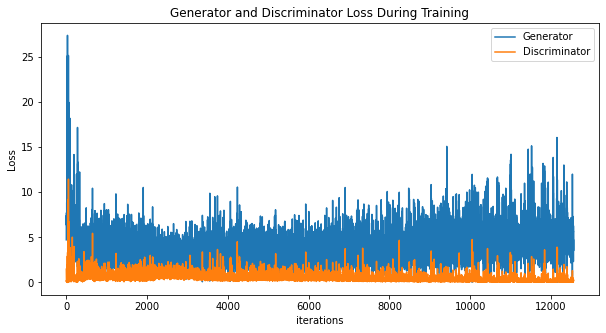

In [227]:
#!g2.mig
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses, label="Generator")
plt.plot(D_losses, label="Discriminator")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [228]:
#!g2.mig
img_list = []

with torch.no_grad():
    fake = generator(fixed_noise).detach().cpu()
img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

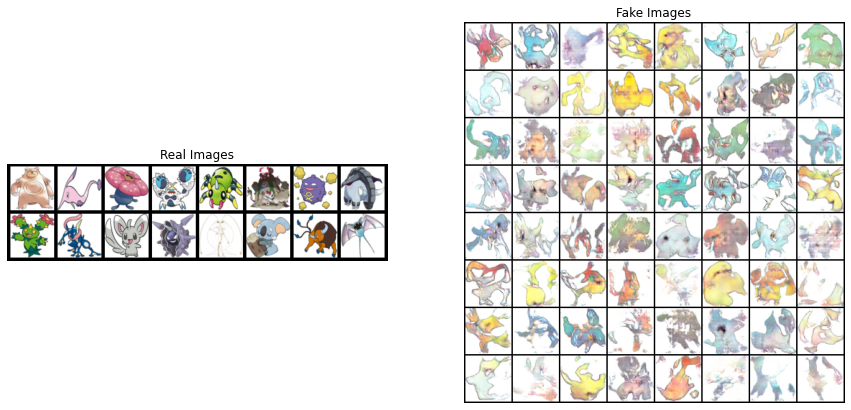

In [230]:
#!g2.mig
# Grab a batch of real images from the dataloader
real_batch = next(iter(pokemon_loader))

# Plot the real images
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch.to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))

# Plot the fake images from the last epoch
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(vutils.make_grid(img_list[-1], padding=5, normalize=True)), (1,2,0))
##plt.imshow(np.transpose(img_list[-1],(1,2,0)))  
plt.show()


In [221]:
#!g2.mig

# ура веса
torch.save(generator.state_dict(), 'weights/G_3.pth')
torch.save(discriminator.state_dict(), 'weights/D_3.pth')